Kornpob Bhirombhakdi, kbhirombhakdi@stsci.edu

# Story
We will generate drzblot images from PID 16042 given X01 location.

# Previously
20200825/02 examined whether small changes in PA_V3 and ORIENTAT in images from the same dithering are normal. We verified that the change is typically small at the order of 0.0001, and can be ignored.

20200825/01 generated hsum.csv for 16042, which can be used here.

# Task
- Choose direct-grism flt pairs.
- Locate X01 in direct flt.
 - X01 Together with GRB190829A, C01, C02, and other important objects that should be recorded given the new FoV from 16042, save ds9 region.
- drzblot flow
- Quality check
 - alignment good?
 - clipping good? (e.g., CR reject)
 - bad pixels on objects?
 
# Resources
- 20200824/06 as the template which was duplicated as the core of this Notebook.
- 20200825/01_16042_hsum/01_16042_hsum_hsum.csv


In [30]:
from hstgrism.container import Container
from hstgrism.computetracenwavelength import ComputeTraceNWavelength
from hstgrism.computexyref import ComputeXYREF
from hstgrism.wfc3irg102 import WFC3IRG102
from hstgrism.wfc3irg141 import WFC3IRG141
from hstgrism.cutout2d import Cutout2D
from hstgrism.flatfield import FlatField
from hstgrism.show_overview import show_overview
import pandas as pd
import os

def generate_flatfield_flt(saveprefix,savefolder,plotformat,overwrite,
                           xyd,confile,beam,gfile,dfile,
                           flatfile,
                           params_overview,
                           filterobs
                          ):
    """
    Use hstgrism to make flatfielded grism flt.
    """
    ##########
    # Make Container
    ##########
    container_params = {'saveprefix':saveprefix,
                        'savefolder':savefolder,
                        'plotformat':plotformat,
                        'overwrite':overwrite
                       }
    containerobj = Container(**container_params)
    ##########
    # Compute xyref
    ##########
    xyref_params = {'xyd':xyd,
                    'xydiff':'default',
                    'xyoff':'default',
                    'confile':confile,
                    'beam':beam,
                    'gfile':gfile,
                    'dfile':dfile,
                    'container':containerobj
                   }
    xyrefobj = ComputeXYREF(**xyref_params)
    xyrefobj.compute()
    xyrefobj.save()
    ##########
    # Map trace and wavelength
    ##########
    xyref = xyrefobj.data['xyref']
    grism_params = {'confile':confile,
                    'beam':beam,
                    'xyref':xyref,
                    'container':containerobj
                   }
    if filterobs == 'G102':
        grismobj = WFC3IRG102(**grism_params)
    elif filterobs == 'G141':
        grismobj = WFC3IRG141(**grism_params)
    else:
        raise ValueError('filterobs = {0} is not supported.'.format(filterobs))
    grismobj.compute()
    grismobj.save()
    ##########
    # show_overview
    ##########
    show_overview(gfile,dfile,xyd,xyref,grismobj.output['xh'],grismobj.output['yh'],grismobj.output['ww'],
                  objname=containerobj.data['saveprefix'],
                  save=True,
                  container=containerobj,
                  params=params_overview
                 )    
    ##########
    # Make cutout
    ##########
    tfile = './{0}/{1}_trace.csv'.format(containerobj.data['savefolder'],containerobj.data['saveprefix'])
    tdata = pd.read_csv(tfile)
    xg = tdata.xh + tdata.xyref[0]
    yg = tdata.yh + tdata.xyref[1]
    halfdy = 20
    tbox = {'xg':xg,'yg':yg,'halfdyup':halfdy,'halfdylow':halfdy}
    bbox={'padxleft': 15, 'padxright': 15, 'padyup': 15, 'padylow': 15}
    image = fits.open(gfile[0])[gfile[1]].data
    do_mask = True
    cutoutobj = Cutout2D(tbox,bbox,image,containerobj)
    cutoutobj.compute(do_mask)
    cutoutobj.save()
    ##########
    # Make flatfield
    ##########
    tfile = './{0}/{1}_trace.csv'.format(containerobj.data['savefolder'],containerobj.data['saveprefix'])
    tdata = pd.read_csv(tfile)
    bbcorner = './{0}/{1}_bbcorner.csv'.format(containerobj.data['savefolder'],containerobj.data['saveprefix'])
    bbdata = pd.read_csv(bbcorner)
    flatobj = FlatField(container=containerobj,flatfile=flatfile,xyref=tdata.xyref,dldp=tdata.dldp)
    flatobj.compute()
    flatobj.save(do_cutout=False)
    ##########
    # Make flatfielded flt
    ##########
    string = './{0}/{1}'.format(containerobj.data['savefolder'],gfile[0].split('/')[-1])
    os.system('cp {0} {1}'.format(gfile[0],string))
    gfile_new = (string,1)
    ffile = ('./{0}/{1}_fullflat.fits'.format(containerobj.data['savefolder'],containerobj.data['saveprefix']),1)
    tmp = fits.open(gfile_new[0])
    tmpdata = tmp[gfile_new[1]].data.copy()
    flatdata = fits.open(ffile[0])[ffile[1]].data.copy()
    m = np.isfinite(flatdata)
    tmpdata[m] = tmpdata[m] / flatdata[m]
    tmp[gfile_new[1]].data = tmpdata.copy()
    tmp.writeto(gfile_new[0],overwrite=True)
    print('Update flatfielded {0}'.format(gfile_new[0]))
    

In [31]:
from hstphot.read_ds9region import read_ds9region
from drizzlepac.astrodrizzle import AstroDrizzle
from drizzlepac import ablot
from astropy.io import fits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob,copy


In [32]:
t = pd.read_csv('./01_16042_hsum/01_16042_hsum_hsum.csv')
t.keys()


Index(['Unnamed: 0', 'index', 'filepath', 'sci_ext_num', 'ROOTNAME',
       'DATE-OBS', 'FILTER', 'PA_V3', 'SUBARRAY', 'POSTARG1', 'POSTARG2',
       'EXPSTART', 'EXPTIME', 'IDCSCALE', 'ORIENTAT'],
      dtype='object')

In [33]:
t[['index','ROOTNAME','DATE-OBS','FILTER','EXPSTART','POSTARG1','POSTARG2','PA_V3','ORIENTAT']]

index   ROOTNAME    DATE-OBS FILTER      EXPSTART   POSTARG1   POSTARG2  \
0       0  ie8a01juq  2020-02-11  F125W  58890.370001 -28.613661 -32.611141   
1       3  ie8a01jvq  2020-02-11   G102  58890.374434 -28.613661 -32.611141   
2      11  ie8a01jxq  2020-02-11   G102  58890.383265 -27.260660 -31.402140   
3      14  ie8a01jyq  2020-02-11   G102  58890.392096 -25.907660 -30.193140   
4       7  ie8a01k0q  2020-02-11  F125W  58890.436309 -28.613661 -32.611141   
5      17  ie8a01k1q  2020-02-11   G102  58890.441066 -27.596661 -32.248138   
6      10  ie8a01k3q  2020-02-11   G102  58890.449897 -26.243660 -31.039141   
7       6  ie8a01k4q  2020-02-11   G102  58890.458728 -24.890659 -29.827141   
8       1  ie8a02xfq  2020-02-14  F140W  58893.150221 -28.613661 -32.611141   
9      20  ie8a02xgq  2020-02-14   G141  58893.154665 -28.613661 -32.611141   
10     12  ie8a02xiq  2020-02-14   G141  58893.163496 -27.260660 -31.402140   
11     13  ie8a02xjq  2020-02-14   G141  58893.172327 -25.907660 -30.193140   
12      2  ie8a02xlq  2020-02-14  F140W  58893.216529 -28.613661 -32.611141   
13     21  ie8a02xmq  2020-02-14   G141  58893.221286 -27.596661 -32.248138   
14      4  ie8a02xoq  2020-02-14   G141  58893.230116 -26.243660 -31.039141   
15      9  ie8a02xpq  2020-02-14   G141  58893.238948 -24.890659 -29.827141   
16     16  ie8a03ltq  2020-02-16  F140W  58895.268415   0.000000   0.000000   
17      8  ie8a03luq  2020-02-16  F140W  58895.273751   0.451100   0.403160   
18     15  ie8a03lwq  2020-02-16  F140W  58895.279086   0.902190   0.806320   
19      5  ie8a03lxq  2020-02-16  F606W  58895.284960   0.000000   0.000000   
20     18  ie8a03lzq  2020-02-16  F606W  58895.290470   0.092350   0.098480   
21     19  ie8a03m1q  2020-02-16  F606W  58895.295979   0.184690   0.196950   

         PA_V3   ORIENTAT  
0   257.169189 -58.139869  
1   257.169189 -58.139869  
2   257.169098 -58.140103  
3   257.169006 -58.140103  
4   257.169189 -58.139869  
5   257.169098 -58.140103  
6   257.169098 -58.140103  
7   257.169006 -58.140103  
8   258.405701 -56.903439  
9   258.405701 -56.903439  
10  258.405701 -56.903439  
11  258.405609 -56.903532  
12  258.405701 -56.903439  
13  258.405701 -56.903439  
14  258.405609 -56.903532  
15  258.405487 -56.903674  
16  259.362915 -56.047914  
17  259.362915 -56.047914  
18  259.362915 -56.047914  
19  259.361908 -55.872668  
20  259.361908 -55.872668  
21  259.361908 -55.872668

# Note
Indices of direct-grism pairs: (starting with direct followed by grisms using the same direct)
- 202002_G102 = [0,3,11,14,17,10,6]
- 202002_G141 = [1,20,12,13,21,4,9]


# drzblot_X01_202002_G102

In [34]:
sourcename = 'X01'
confile = '/Users/kbhirombhakdi/_work/_calib_files/WFC3.IR.G102.cal.V4.32/G102.F125W.V4.32.conf'
flatfile = '/Users/kbhirombhakdi/_work/_calib_files/WFC3.IR.G102.cal.V4.32/WFC3.IR.G102.flat.2.fits'
dateobs = '202002'
filterobs = 'G102'
identifier = '{0}_{1}_{2}'.format(sourcename,dateobs,filterobs)
ds9file = '/Users/kbhirombhakdi/_work/_data/16042/HST/ie8a01juq/ie8a01juq.reg'


In [35]:
dglist = [0,3,11,14,17,10,6]
flist = []
for i in dglist:
    flist.append(t[t['index']==i].filepath.values[0])
flist


['/Users/kbhirombhakdi/_work/_data/16042/HST/ie8a01juq/ie8a01juq_flt.fits',
 '/Users/kbhirombhakdi/_work/_data/16042/HST/ie8a01jvq/ie8a01jvq_flt.fits',
 '/Users/kbhirombhakdi/_work/_data/16042/HST/ie8a01jxq/ie8a01jxq_flt.fits',
 '/Users/kbhirombhakdi/_work/_data/16042/HST/ie8a01jyq/ie8a01jyq_flt.fits',
 '/Users/kbhirombhakdi/_work/_data/16042/HST/ie8a01k1q/ie8a01k1q_flt.fits',
 '/Users/kbhirombhakdi/_work/_data/16042/HST/ie8a01k3q/ie8a01k3q_flt.fits',
 '/Users/kbhirombhakdi/_work/_data/16042/HST/ie8a01k4q/ie8a01k4q_flt.fits']

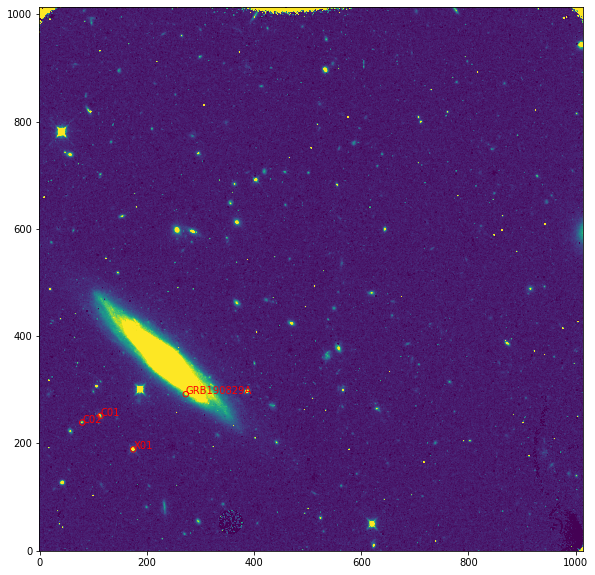

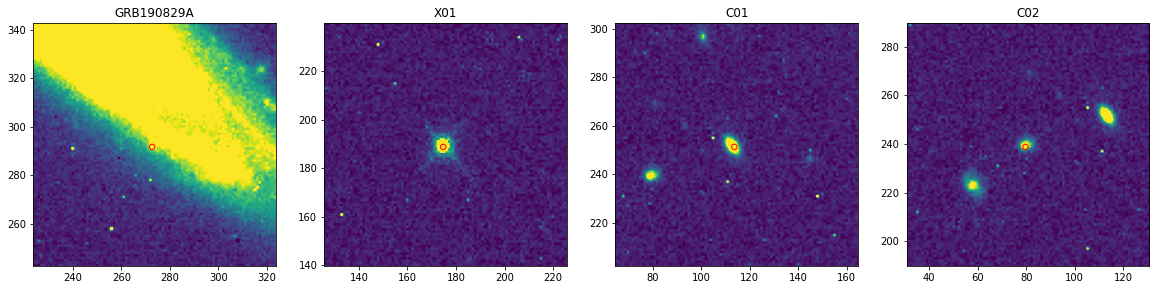

In [36]:
tmp = ds9file
sourcelist = read_ds9region(tmp)
tmpdata = fits.open(flist[0])[1].data
plt.figure(figsize=(10,10))
m = np.isfinite(tmpdata)
vmin,vmax = np.percentile(tmpdata[m],5.),np.percentile(tmpdata[m],99.)
plt.imshow(tmpdata,origin='lower',cmap='viridis',vmin=vmin,vmax=vmax)

for i in sourcelist:
    x,y = sourcelist[i]
    plt.scatter(x-1,y-1,s=30,edgecolor='red',facecolor='None',label=i)
    plt.annotate(i,(x-1,y-1),fontsize=10,color='red')
    
n = len(sourcelist)
dx,dy = 50,50
fig = plt.figure(figsize=(5*n,5))
for i,ii in enumerate(sourcelist):
    x,y = sourcelist[ii]
    ax = fig.add_subplot(1,n,i+1)
    ax.imshow(tmpdata,origin='lower',cmap='viridis',vmin=vmin,vmax=vmax)
    ax.scatter(x-1,y-1,s=30,edgecolor='red',facecolor='None',label=i)
    ax.set_xlim(x-dx,x+dx)
    ax.set_ylim(y-dy,y+dy)
    ax.set_title(ii,fontsize=12)
    

Save ./ie8a01jvq_X01_202002_G102/ie8a01jvq_X01_202002_G102_xyref.csv
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Save ./ie8a01jvq_X01_202002_G102/ie8a01jvq_X01_202002_G102_trace.csv
Save ./ie8a01jvq_X01_202002_G102/ie8a01jvq_X01_202002_G102_overview.pdf

Save ./ie8a01jvq_X01_202002_G102/ie8a01jvq_X01_202002_G102_tbox.csv
Save ./ie8a01jvq_X01_202002_G102/ie8a01jvq_X01_202002_G102_bbox.csv
Save ./ie8a01jvq_X01_202002_G102/ie8a01jvq_X01_202002_G102_bbcorner.csv
Save ./ie8a01jvq_X01_202002_G102/ie8a01jvq_X01_202002_G102_cutout.fits
Save ./ie8a01jvq_X01_202002_G102/ie8a01jvq_X01_202002_G102_mask.fits
Save ./ie8a01jvq_X01_202002_G102/ie8a01jvq_X01_202002_G102_fullflat.fits
Update flatfielded ./ie8a01jvq_X01_202002_G102/ie8a01jvq_flt.fits
Save ./ie8a01jxq_X01_202002_G102/ie8a01jxq_X01_202002_G102_xyref.csv
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale =

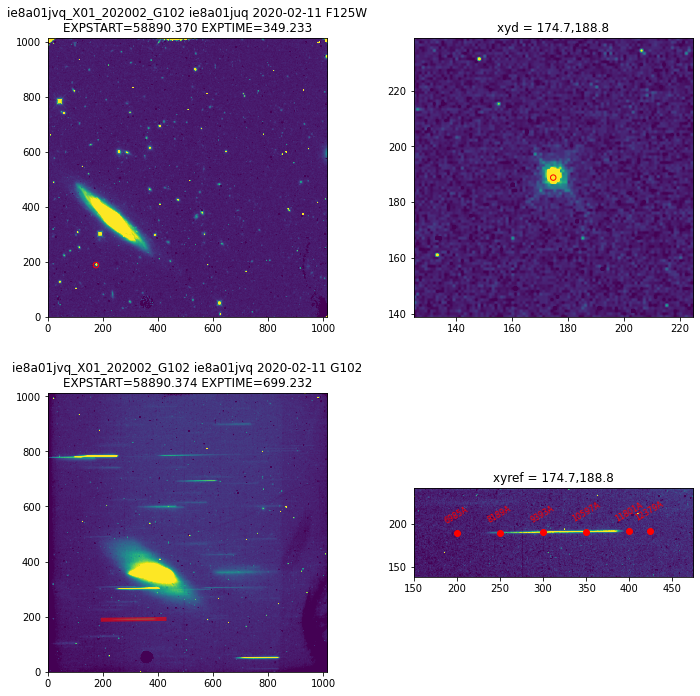

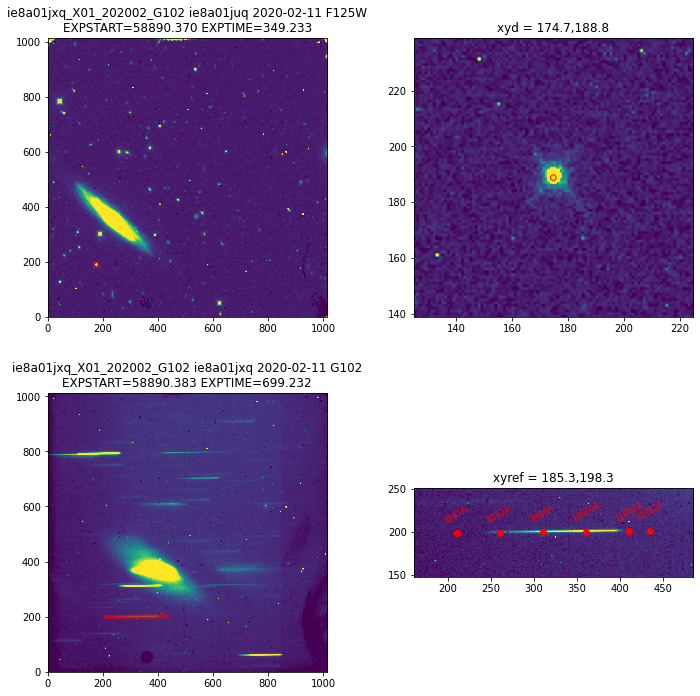

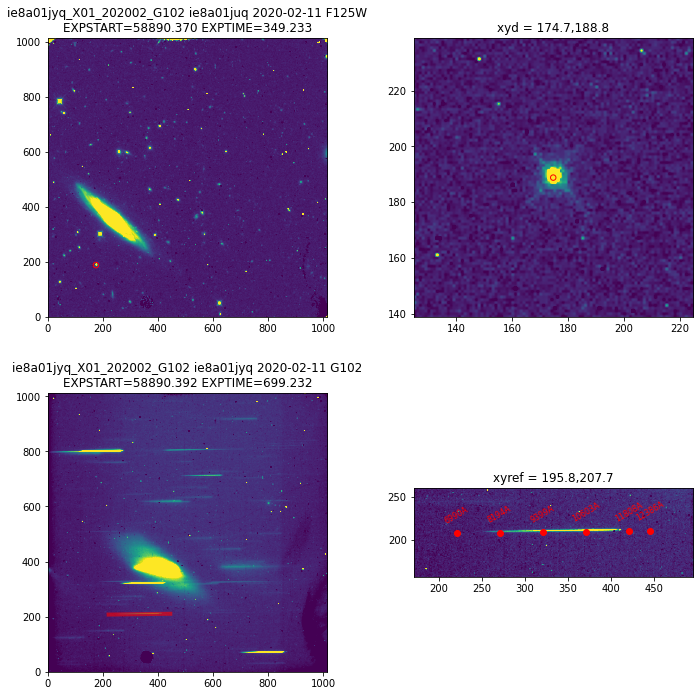

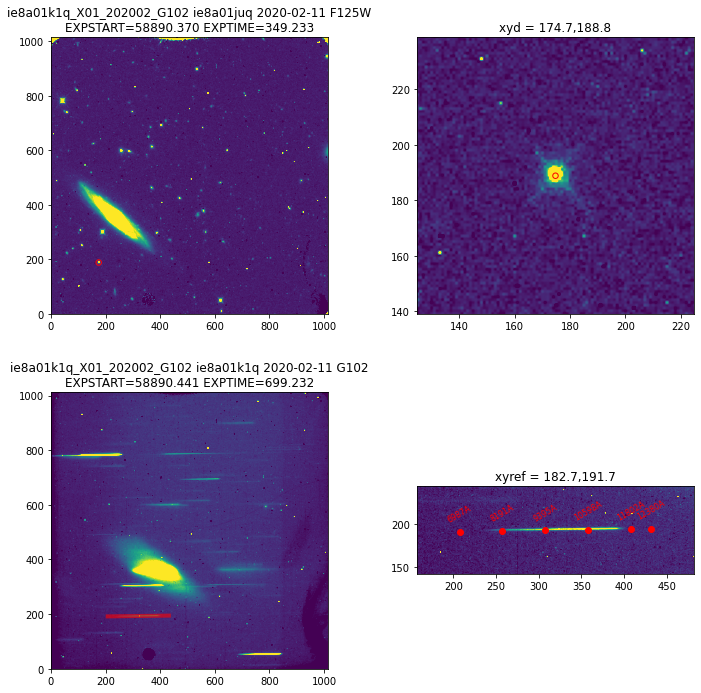

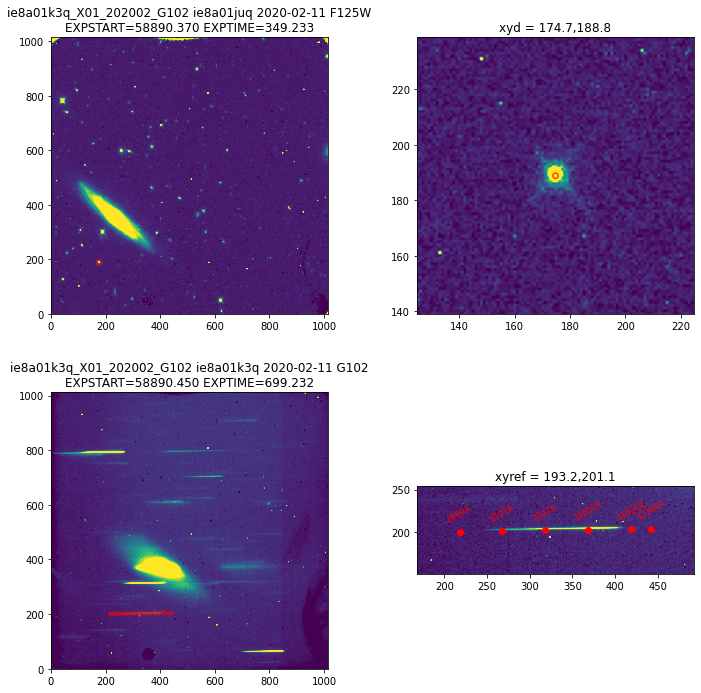

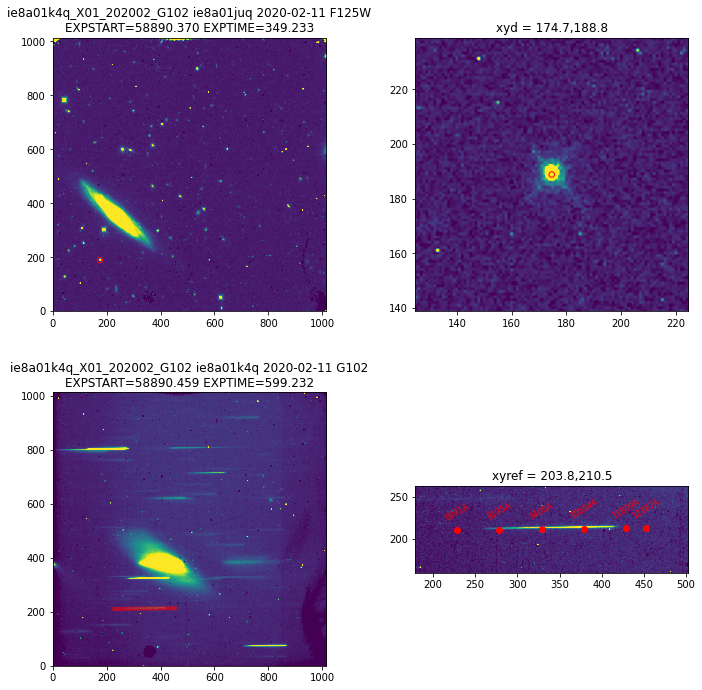

In [37]:
for i,ii in enumerate(flist):
    if i == 0:
        continue
    for j,jj in enumerate(sourcelist):
        if jj != sourcename:
            continue
        dfile = (flist[0],1)
        gfile = (flist[i],1)
        rootname = fits.open(gfile[0])[0].header['ROOTNAME']
        sourcename = jj
        saveprefix = '{0}_{1}'.format(rootname,identifier)
        savefolder = saveprefix
        plotformat = 'pdf'
        overwrite = False
        x,y = sourcelist[sourcename]
        xyd = (x-1,y-1)
        beam = 'A'
        params_overview = {'figsize': (10, 10), 
                           '221': {'minmax': (5.0, 99.0), 'cmap': 'viridis', 's': 30, 'facecolor': 'None', 'edgecolor': 'red', 'fontsize': 12, 'title': 'default'}, 
                           '222': {'minmax': (5.0, 99.0), 'cmap': 'viridis', 's': 30, 'facecolor': 'None', 'edgecolor': 'red', 'padxy': (50, 50), 'fontsize': 12, 'title': 'default'}, 
                           '223': {'minmax': (5.0, 99.0), 'cmap': 'viridis', 's': 30, 'facecolor': 'None', 'edgecolor': 'red', 'color': 'red', 'ls': '-', 'lw': 4, 'alpha': 0.6, 'fontsize': 12, 'title': 'default'}, 
                           '224': {'minmax': (5.0, 99.0), 'cmap': 'viridis', 's': 30, 'facecolor': 'None', 'edgecolor': 'red', 'color': 'red', 'ls': '-', 'lw': 0, 'alpha': 0.6, 'padxy': (50, 50), 'tickperx': 50, 'annotate_marker': 'ro', 'annotate_color': 'red', 'annotate_fontsize': 8, 'annotate_rotation': 30.0, 'fontsize': 12, 'title': 'default'}}
        generate_flatfield_flt(saveprefix,savefolder,plotformat,overwrite,
                                   xyd,confile,beam,gfile,dfile,
                                   flatfile,
                               params_overview,filterobs
                                  )
        

In [38]:
# make drzlist
drzlist = []
for ii,i in enumerate(flist):
    if ii==0:
        continue
    tmp = i.split('/')[-1]
    tmpp = tmp.split('_')[0]
    string = './{0}_{1}/{2}'.format(tmpp,identifier,tmp)
    drzlist.append(string)
drzlist


['./ie8a01jvq_X01_202002_G102/ie8a01jvq_flt.fits',
 './ie8a01jxq_X01_202002_G102/ie8a01jxq_flt.fits',
 './ie8a01jyq_X01_202002_G102/ie8a01jyq_flt.fits',
 './ie8a01k1q_X01_202002_G102/ie8a01k1q_flt.fits',
 './ie8a01k3q_X01_202002_G102/ie8a01k3q_flt.fits',
 './ie8a01k4q_X01_202002_G102/ie8a01k4q_flt.fits']

In [39]:
# drizzle
params_drz = {'build':True,
          'restore':False,
          'overwrite':False,
          'clean':True,
          # Step 1 Statis Mask
          'static':False,
          # Step 2 Sky Sub
          'skysub':True,
          'skymethod':'localmin',
          'skystat':'median',
          # Step 3 Driz Sep
          'driz_separate':True,
          'driz_sep_kernel':'turbo',
          'driz_sep_pixfrac':1., # Set this high for CR
#           'driz_sep_scale':0.05, # Smaller than native size, better for CR
          # Step 4 Median
          'median':True,
          'combine_type':'median',
          'combine_nhigh':1, # Reject highest values before computing median, good for CR
          # Step 5 Blot
          'blot':True,
          'blot_interp':'poly5',
          'blot_addsky':True,
          # Step 6 CR
          'driz_cr':True,
          'driz_cr_corr':True,
          'driz_cr_ctegrow':0,
          # Step 7 Final Combine
          'driz_combine':True,
              'final_refimage':drzlist[0]
         }
AstroDrizzle(input=drzlist,
             output='{0}'.format(identifier),
             **params_drz
            )


Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 3.1.6 (2020-02-19 16:16:30 -0500) started at: 13:42:38.607 (25/08/2020)

==== Processing Step  Initialization  started at  13:42:38.610 (25/08/2020)

Creating OUTPUT WCS from ./ie8a01jvq_X01_202002_G102/ie8a01jvq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -1.9929605998518e-05 -2.8555491417348e-05
CD_21  CD_22: -3.1903796927917e-05 1.7705437444501e-05
CRVAL    : 44.532901104955 -8.9614767570276
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13542133229153427
ORIENTAT : -58.19959036736756
********************************************************************************
*
*  Estimated memory usage:  up to 117 Mb.
*  Output image size:       1014 X 1014 pixels. 
*  Output image file:       ~ 11 Mb. 
*  Cores available:         6
*
********************************************************************************
==== Processing Step Initialization finished at 13:42:39.761 (25/08/2020)
==== Processing Step  Static Mask  star

reference sky value for image '/Users/kbhirombhakdi/_work/Sidekicks/20200825/ie8a01k1q_X01_202002_G102/ie8a01k1q_flt.fits' is 582.2135554199597
reference sky value for image '/Users/kbhirombhakdi/_work/Sidekicks/20200825/ie8a01k3q_X01_202002_G102/ie8a01k3q_flt.fits' is 555.8094397499391
reference sky value for image '/Users/kbhirombhakdi/_work/Sidekicks/20200825/ie8a01k4q_X01_202002_G102/ie8a01k4q_flt.fits' is 465.5894429512064
Saving output median image to: 'X01_202002_G102_med.fits'
==== Processing Step Create Median finished at 13:42:42.48 (25/08/2020)
==== Processing Step  Blot  started at  13:42:42.488 (25/08/2020)

    Blot: creating blotted image:  /Users/kbhirombhakdi/_work/Sidekicks/20200825/ie8a01jvq_X01_202002_G102/ie8a01jvq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: /Users/kbhirombhakdi/_work/Sidekicks/20200825/ie8a01jvq_X01_202002_G102/ie8a01jvq_sci1_blt.fits
Writing out image to disk: /Users/kbhirombhakdi/_work/Sidek

In [40]:
# setup for drzblot
drzfile = glob.glob('./{0}_drz.fits'.format(identifier))[0]
reffile = drzlist[0]
skyval = fits.open(reffile)[1].header['MDRIZSKY']
rootname = reffile.split('/')[-1].split('_')[0]
outdata = './drzblot_{0}/{1}_drzblot_sci.fits'.format(identifier,rootname)
drzfile,reffile,skyval,outdata


('./X01_202002_G102_drz.fits',
 './ie8a01jvq_X01_202002_G102/ie8a01jvq_flt.fits',
 0.8345457911491394,
 './drzblot_X01_202002_G102/ie8a01jvq_drzblot_sci.fits')

In [41]:
# facilitate creating folder
saveprefix = rootname
savefolder = 'drzblot_{0}'.format(identifier)
plotformat = 'pdf'
overwrite = False
containter_drzblot = Container(saveprefix,savefolder,plotformat,overwrite)
# blot
ablot.blot('{0}[1]'.format(drzfile),'{0}[1]'.format(reffile),addsky=False,skyval=skyval,
           outdata=outdata,in_units='counts',out_units='cps')
# replace back
os.system('cp {0} ./{1}/'.format(flist[1],savefolder))
string = './{0}/{1}'.format(savefolder,flist[1].split('/')[-1])
tmp = fits.open(string)
tmpp = fits.open(outdata)
tmp[1].data = tmpp[1].data.copy()
tmp.writeto(string,overwrite=True)
print('Save {0}'.format(string))


Using coordinate transformation defined by user...
Added 0.8345457911491394 counts back in to blotted image as sky.
Created output image: ./drzblot_X01_202002_G102/ie8a01jvq_drzblot_sci.fits
Save ./drzblot_X01_202002_G102/ie8a01jvq_flt.fits


In [45]:
# rename flt.fits to drzblot.fits
string2 = string.split('/')[-1].split('_')[0] + '_drzblot.fits'
string2 = '/'.join(string.split('/')[0:-1]) + '/' + string2
os.system('cp {0} {1}'.format(string,string2))
os.system('rm {0}'.format(string))


0

# X01_202002_G141

In [46]:
sourcename = 'X01'
confile = '/Users/kbhirombhakdi/_work/_calib_files/WFC3.IR.G141.cal.V4.32/G141.F140W.V4.32.conf'
flatfile = '/Users/kbhirombhakdi/_work/_calib_files/WFC3.IR.G102.cal.V4.32/WFC3.IR.G102.flat.2.fits'
dateobs = '202002'
filterobs = 'G141'
identifier = '{0}_{1}_{2}'.format(sourcename,dateobs,filterobs)
ds9file = '/Users/kbhirombhakdi/_work/_data/16042/HST/ie8a02xfq/ie8a02xfq.reg'


In [47]:
dglist = [1,20,12,13,21,4,9]
flist = []
for i in dglist:
    flist.append(t[t['index']==i].filepath.values[0])
flist


['/Users/kbhirombhakdi/_work/_data/16042/HST/ie8a02xfq/ie8a02xfq_flt.fits',
 '/Users/kbhirombhakdi/_work/_data/16042/HST/ie8a02xgq/ie8a02xgq_flt.fits',
 '/Users/kbhirombhakdi/_work/_data/16042/HST/ie8a02xiq/ie8a02xiq_flt.fits',
 '/Users/kbhirombhakdi/_work/_data/16042/HST/ie8a02xjq/ie8a02xjq_flt.fits',
 '/Users/kbhirombhakdi/_work/_data/16042/HST/ie8a02xmq/ie8a02xmq_flt.fits',
 '/Users/kbhirombhakdi/_work/_data/16042/HST/ie8a02xoq/ie8a02xoq_flt.fits',
 '/Users/kbhirombhakdi/_work/_data/16042/HST/ie8a02xpq/ie8a02xpq_flt.fits']

Save ./ie8a02xgq_X01_202002_G141/ie8a02xgq_X01_202002_G141_xyref.csv
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Save ./ie8a02xgq_X01_202002_G141/ie8a02xgq_X01_202002_G141_trace.csv
Save ./ie8a02xgq_X01_202002_G141/ie8a02xgq_X01_202002_G141_overview.pdf

Save ./ie8a02xgq_X01_202002_G141/ie8a02xgq_X01_202002_G141_tbox.csv
Save ./ie8a02xgq_X01_202002_G141/ie8a02xgq_X01_202002_G141_bbox.csv
Save ./ie8a02xgq_X01_202002_G141/ie8a02xgq_X01_202002_G141_bbcorner.csv
Save ./ie8a02xgq_X01_202002_G141/ie8a02xgq_X01_202002_G141_cutout.fits
Save ./ie8a02xgq_X01_202002_G141/ie8a02xgq_X01_202002_G141_mask.fits
Save ./ie8a02xgq_X01_202002_G141/ie8a02xgq_X01_202002_G141_fullflat.fits


/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in true_divide


Update flatfielded ./ie8a02xgq_X01_202002_G141/ie8a02xgq_flt.fits
Save ./ie8a02xiq_X01_202002_G141/ie8a02xiq_X01_202002_G141_xyref.csv
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Save ./ie8a02xiq_X01_202002_G141/ie8a02xiq_X01_202002_G141_trace.csv
Save ./ie8a02xiq_X01_202002_G141/ie8a02xiq_X01_202002_G141_overview.pdf

Save ./ie8a02xiq_X01_202002_G141/ie8a02xiq_X01_202002_G141_tbox.csv
Save ./ie8a02xiq_X01_202002_G141/ie8a02xiq_X01_202002_G141_bbox.csv
Save ./ie8a02xiq_X01_202002_G141/ie8a02xiq_X01_202002_G141_bbcorner.csv
Save ./ie8a02xiq_X01_202002_G141/ie8a02xiq_X01_202002_G141_cutout.fits
Save ./ie8a02xiq_X01_202002_G141/ie8a02xiq_X01_202002_G141_mask.fits
Save ./ie8a02xiq_X01_202002_G141/ie8a02xiq_X01_202002_G141_fullflat.fits


/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in true_divide


Update flatfielded ./ie8a02xiq_X01_202002_G141/ie8a02xiq_flt.fits
Save ./ie8a02xjq_X01_202002_G141/ie8a02xjq_X01_202002_G141_xyref.csv
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Save ./ie8a02xjq_X01_202002_G141/ie8a02xjq_X01_202002_G141_trace.csv
Save ./ie8a02xjq_X01_202002_G141/ie8a02xjq_X01_202002_G141_overview.pdf

Save ./ie8a02xjq_X01_202002_G141/ie8a02xjq_X01_202002_G141_tbox.csv
Save ./ie8a02xjq_X01_202002_G141/ie8a02xjq_X01_202002_G141_bbox.csv
Save ./ie8a02xjq_X01_202002_G141/ie8a02xjq_X01_202002_G141_bbcorner.csv
Save ./ie8a02xjq_X01_202002_G141/ie8a02xjq_X01_202002_G141_cutout.fits
Save ./ie8a02xjq_X01_202002_G141/ie8a02xjq_X01_202002_G141_mask.fits
Save ./ie8a02xjq_X01_202002_G141/ie8a02xjq_X01_202002_G141_fullflat.fits


/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in true_divide


Update flatfielded ./ie8a02xjq_X01_202002_G141/ie8a02xjq_flt.fits
Save ./ie8a02xmq_X01_202002_G141/ie8a02xmq_X01_202002_G141_xyref.csv
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Save ./ie8a02xmq_X01_202002_G141/ie8a02xmq_X01_202002_G141_trace.csv
Save ./ie8a02xmq_X01_202002_G141/ie8a02xmq_X01_202002_G141_overview.pdf

Save ./ie8a02xmq_X01_202002_G141/ie8a02xmq_X01_202002_G141_tbox.csv
Save ./ie8a02xmq_X01_202002_G141/ie8a02xmq_X01_202002_G141_bbox.csv
Save ./ie8a02xmq_X01_202002_G141/ie8a02xmq_X01_202002_G141_bbcorner.csv
Save ./ie8a02xmq_X01_202002_G141/ie8a02xmq_X01_202002_G141_cutout.fits
Save ./ie8a02xmq_X01_202002_G141/ie8a02xmq_X01_202002_G141_mask.fits
Save ./ie8a02xmq_X01_202002_G141/ie8a02xmq_X01_202002_G141_fullflat.fits


/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in true_divide


Update flatfielded ./ie8a02xmq_X01_202002_G141/ie8a02xmq_flt.fits
Save ./ie8a02xoq_X01_202002_G141/ie8a02xoq_X01_202002_G141_xyref.csv
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Save ./ie8a02xoq_X01_202002_G141/ie8a02xoq_X01_202002_G141_trace.csv
Save ./ie8a02xoq_X01_202002_G141/ie8a02xoq_X01_202002_G141_overview.pdf

Save ./ie8a02xoq_X01_202002_G141/ie8a02xoq_X01_202002_G141_tbox.csv
Save ./ie8a02xoq_X01_202002_G141/ie8a02xoq_X01_202002_G141_bbox.csv
Save ./ie8a02xoq_X01_202002_G141/ie8a02xoq_X01_202002_G141_bbcorner.csv
Save ./ie8a02xoq_X01_202002_G141/ie8a02xoq_X01_202002_G141_cutout.fits
Save ./ie8a02xoq_X01_202002_G141/ie8a02xoq_X01_202002_G141_mask.fits
Save ./ie8a02xoq_X01_202002_G141/ie8a02xoq_X01_202002_G141_fullflat.fits


/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in true_divide


Update flatfielded ./ie8a02xoq_X01_202002_G141/ie8a02xoq_flt.fits
Save ./ie8a02xpq_X01_202002_G141/ie8a02xpq_X01_202002_G141_xyref.csv
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Rescale = False
Perform compute
Save ./ie8a02xpq_X01_202002_G141/ie8a02xpq_X01_202002_G141_trace.csv
Save ./ie8a02xpq_X01_202002_G141/ie8a02xpq_X01_202002_G141_overview.pdf

Save ./ie8a02xpq_X01_202002_G141/ie8a02xpq_X01_202002_G141_tbox.csv
Save ./ie8a02xpq_X01_202002_G141/ie8a02xpq_X01_202002_G141_bbox.csv
Save ./ie8a02xpq_X01_202002_G141/ie8a02xpq_X01_202002_G141_bbcorner.csv
Save ./ie8a02xpq_X01_202002_G141/ie8a02xpq_X01_202002_G141_cutout.fits
Save ./ie8a02xpq_X01_202002_G141/ie8a02xpq_X01_202002_G141_mask.fits
Save ./ie8a02xpq_X01_202002_G141/ie8a02xpq_X01_202002_G141_fullflat.fits
Update flatfielded ./ie8a02xpq_X01_202002_G141/ie8a02xpq_flt.fits
Setting up logfile :  astrodrizzle.log
AstroDrizzle Version 3.1.6 (2020-02-19 16:16:30 -0500) started at: 13

/Users/kbhirombhakdi/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in true_divide


Creating OUTPUT WCS from ./ie8a02xgq_X01_202002_G141/ie8a02xgq_flt.fits[1]
WCS Keywords

CD_11  CD_12: -2.0613455533815e-05 -2.8166797245663e-05
CD_21  CD_22: -3.1466330079188e-05 1.8317547605308e-05
CRVAL    : 44.53283072447 -8.9612438312862
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13542147699295284
ORIENTAT : -56.963079436501
********************************************************************************
*
*  Estimated memory usage:  up to 117 Mb.
*  Output image size:       1014 X 1014 pixels. 
*  Output image file:       ~ 11 Mb. 
*  Cores available:         6
*
********************************************************************************
==== Processing Step Initialization finished at 13:50:46.58 (25/08/2020)
==== Processing Step  Static Mask  started at  13:50:46.587 (25/08/2020)

==== Processing Step Static Mask finished at 13:50:46.589 (25/08/2020)
==== Processing Step  Subtract Sky  started at  13:50:46.590 (25/08/2020)

***** skymatch started on 2020-08

reference sky value for image '/Users/kbhirombhakdi/_work/Sidekicks/20200825/ie8a02xpq_X01_202002_G141/ie8a02xpq_flt.fits' is 880.3465643300561
Saving output median image to: 'X01_202002_G141_med.fits'
==== Processing Step Create Median finished at 13:50:49.370 (25/08/2020)
==== Processing Step  Blot  started at  13:50:49.372 (25/08/2020)

    Blot: creating blotted image:  /Users/kbhirombhakdi/_work/Sidekicks/20200825/ie8a02xgq_X01_202002_G141/ie8a02xgq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: /Users/kbhirombhakdi/_work/Sidekicks/20200825/ie8a02xgq_X01_202002_G141/ie8a02xgq_sci1_blt.fits
Writing out image to disk: /Users/kbhirombhakdi/_work/Sidekicks/20200825/ie8a02xgq_X01_202002_G141/ie8a02xgq_sci1_blt.fits
    Blot: creating blotted image:  /Users/kbhirombhakdi/_work/Sidekicks/20200825/ie8a02xiq_X01_202002_G141/ie8a02xiq_flt.fits[sci,1]
Using default C-based coordinate transformation...
-Generating simple FITS output: /Users/

0

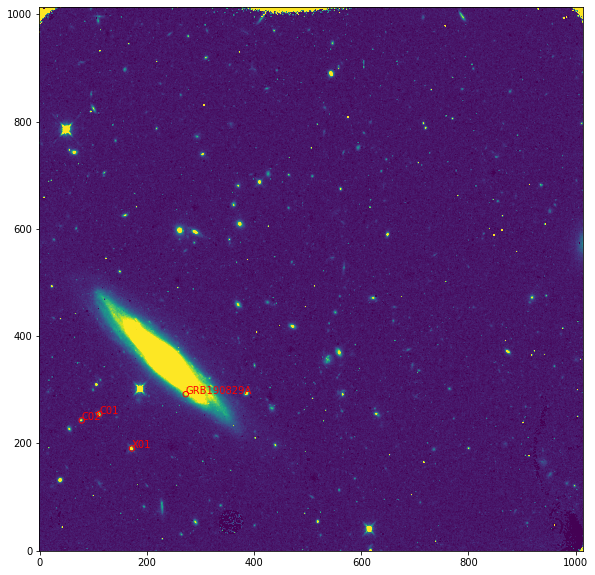

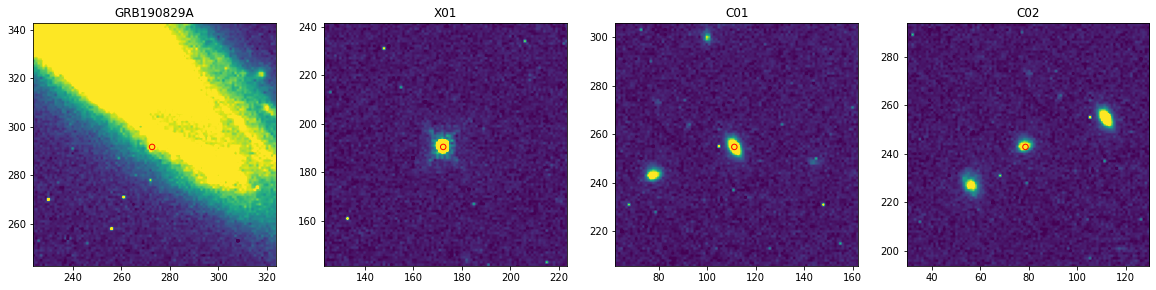

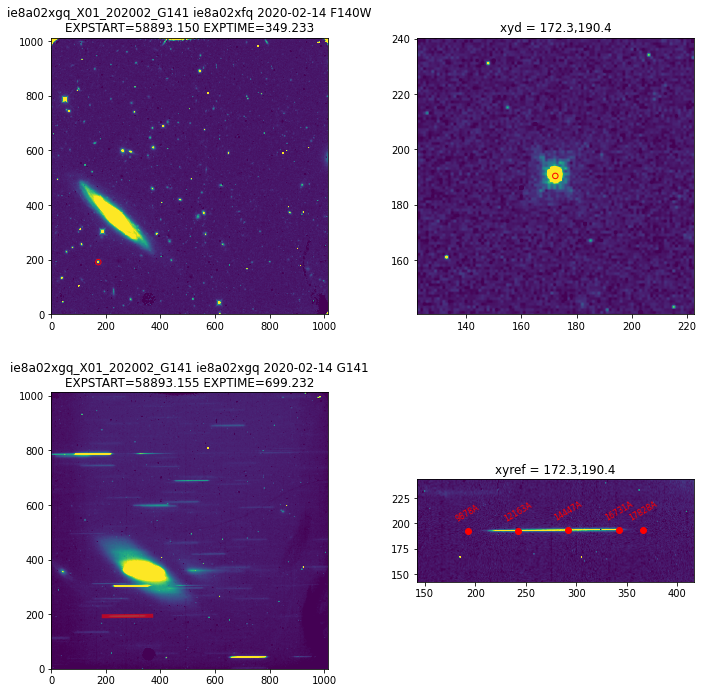

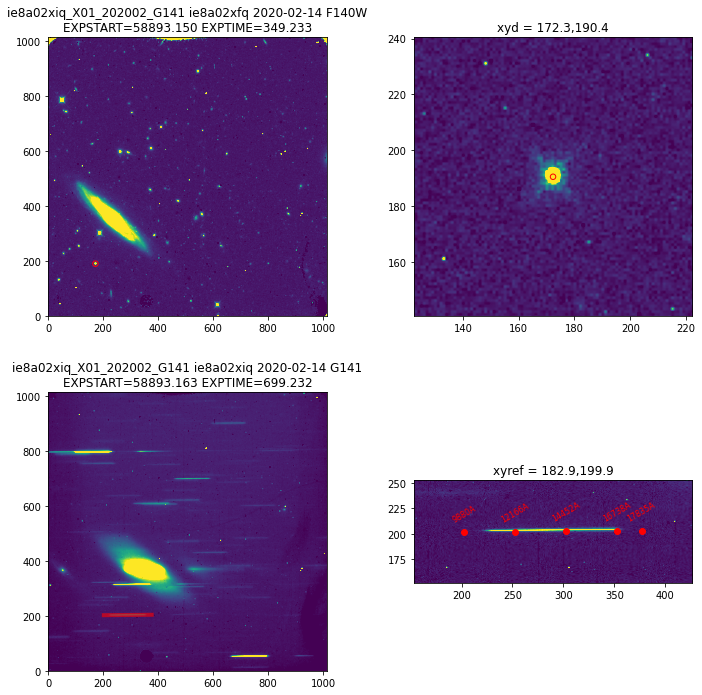

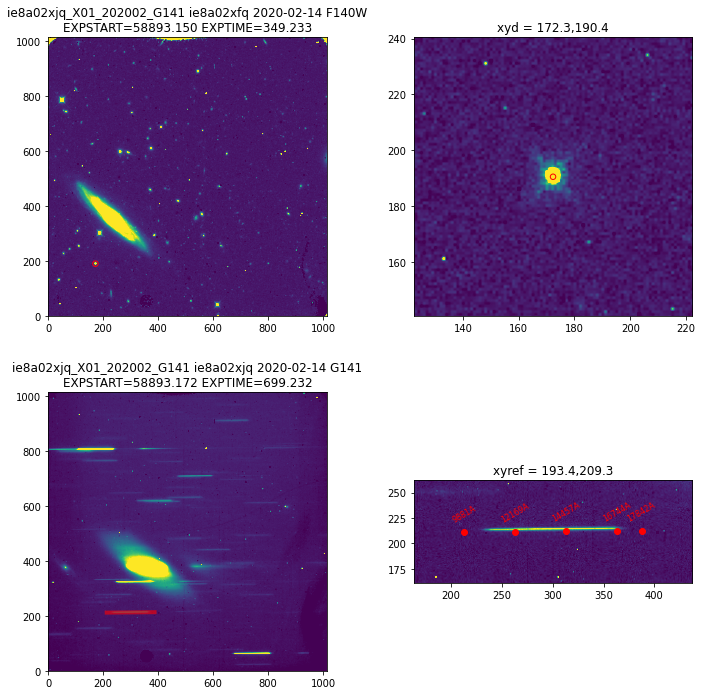

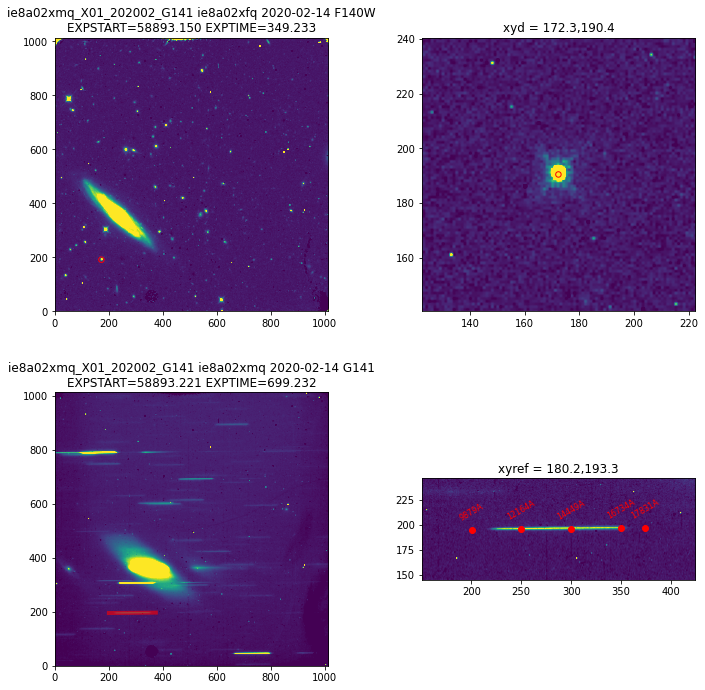

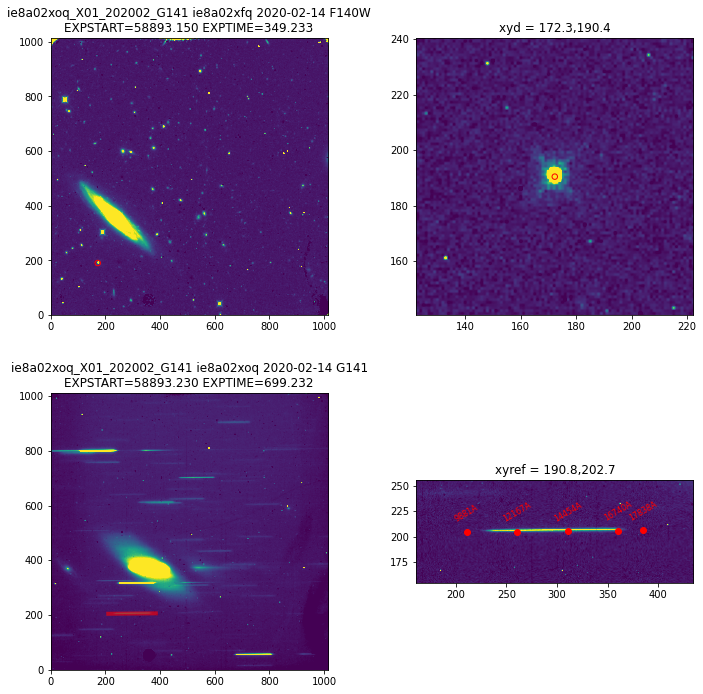

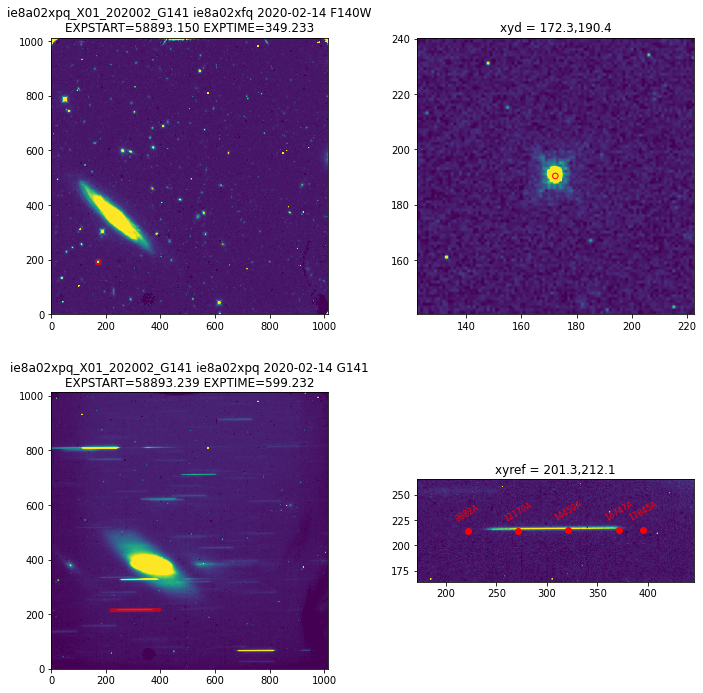

In [48]:
tmp = ds9file
sourcelist = read_ds9region(tmp)
tmpdata = fits.open(flist[0])[1].data
plt.figure(figsize=(10,10))
m = np.isfinite(tmpdata)
vmin,vmax = np.percentile(tmpdata[m],5.),np.percentile(tmpdata[m],99.)
plt.imshow(tmpdata,origin='lower',cmap='viridis',vmin=vmin,vmax=vmax)

for i in sourcelist:
    x,y = sourcelist[i]
    plt.scatter(x-1,y-1,s=30,edgecolor='red',facecolor='None',label=i)
    plt.annotate(i,(x-1,y-1),fontsize=10,color='red')
    
n = len(sourcelist)
dx,dy = 50,50
fig = plt.figure(figsize=(5*n,5))
for i,ii in enumerate(sourcelist):
    x,y = sourcelist[ii]
    ax = fig.add_subplot(1,n,i+1)
    ax.imshow(tmpdata,origin='lower',cmap='viridis',vmin=vmin,vmax=vmax)
    ax.scatter(x-1,y-1,s=30,edgecolor='red',facecolor='None',label=i)
    ax.set_xlim(x-dx,x+dx)
    ax.set_ylim(y-dy,y+dy)
    ax.set_title(ii,fontsize=12)

for i,ii in enumerate(flist):
    if i == 0:
        continue
    for j,jj in enumerate(sourcelist):
        if jj != sourcename:
            continue
        dfile = (flist[0],1)
        gfile = (flist[i],1)
        rootname = fits.open(gfile[0])[0].header['ROOTNAME']
        sourcename = jj
        saveprefix = '{0}_{1}'.format(rootname,identifier)
        savefolder = saveprefix
        plotformat = 'pdf'
        overwrite = False
        x,y = sourcelist[sourcename]
        xyd = (x-1,y-1)
        beam = 'A'
        params_overview = {'figsize': (10, 10), 
                           '221': {'minmax': (5.0, 99.0), 'cmap': 'viridis', 's': 30, 'facecolor': 'None', 'edgecolor': 'red', 'fontsize': 12, 'title': 'default'}, 
                           '222': {'minmax': (5.0, 99.0), 'cmap': 'viridis', 's': 30, 'facecolor': 'None', 'edgecolor': 'red', 'padxy': (50, 50), 'fontsize': 12, 'title': 'default'}, 
                           '223': {'minmax': (5.0, 99.0), 'cmap': 'viridis', 's': 30, 'facecolor': 'None', 'edgecolor': 'red', 'color': 'red', 'ls': '-', 'lw': 4, 'alpha': 0.6, 'fontsize': 12, 'title': 'default'}, 
                           '224': {'minmax': (5.0, 99.0), 'cmap': 'viridis', 's': 30, 'facecolor': 'None', 'edgecolor': 'red', 'color': 'red', 'ls': '-', 'lw': 0, 'alpha': 0.6, 'padxy': (50, 50), 'tickperx': 50, 'annotate_marker': 'ro', 'annotate_color': 'red', 'annotate_fontsize': 8, 'annotate_rotation': 30.0, 'fontsize': 12, 'title': 'default'}}
        generate_flatfield_flt(saveprefix,savefolder,plotformat,overwrite,
                                   xyd,confile,beam,gfile,dfile,
                                   flatfile,
                               params_overview,filterobs
                                  )
        
# make drzlist
drzlist = []
for ii,i in enumerate(flist):
    if ii==0:
        continue
    tmp = i.split('/')[-1]
    tmpp = tmp.split('_')[0]
    string = './{0}_{1}/{2}'.format(tmpp,identifier,tmp)
    drzlist.append(string)
drzlist

# drizzle
params_drz = {'build':True,
          'restore':False,
          'overwrite':False,
          'clean':True,
          # Step 1 Statis Mask
          'static':False,
          # Step 2 Sky Sub
          'skysub':True,
          'skymethod':'localmin',
          'skystat':'median',
          # Step 3 Driz Sep
          'driz_separate':True,
          'driz_sep_kernel':'turbo',
          'driz_sep_pixfrac':1., # Set this high for CR
#           'driz_sep_scale':0.05, # Smaller than native size, better for CR
          # Step 4 Median
          'median':True,
          'combine_type':'median',
          'combine_nhigh':1, # Reject highest values before computing median, good for CR
          # Step 5 Blot
          'blot':True,
          'blot_interp':'poly5',
          'blot_addsky':True,
          # Step 6 CR
          'driz_cr':True,
          'driz_cr_corr':True,
          'driz_cr_ctegrow':0,
          # Step 7 Final Combine
          'driz_combine':True,
              'final_refimage':drzlist[0]
         }
AstroDrizzle(input=drzlist,
             output='{0}'.format(identifier),
             **params_drz
            )

# setup for drzblot
drzfile = glob.glob('./{0}_drz.fits'.format(identifier))[0]
reffile = drzlist[0]
skyval = fits.open(reffile)[1].header['MDRIZSKY']
rootname = reffile.split('/')[-1].split('_')[0]
outdata = './drzblot_{0}/{1}_drzblot_sci.fits'.format(identifier,rootname)
drzfile,reffile,skyval,outdata

# facilitate creating folder
saveprefix = rootname
savefolder = 'drzblot_{0}'.format(identifier)
plotformat = 'pdf'
overwrite = False
containter_drzblot = Container(saveprefix,savefolder,plotformat,overwrite)
# blot
ablot.blot('{0}[1]'.format(drzfile),'{0}[1]'.format(reffile),addsky=False,skyval=skyval,
           outdata=outdata,in_units='counts',out_units='cps')
# replace back
os.system('cp {0} ./{1}/'.format(flist[1],savefolder))
string = './{0}/{1}'.format(savefolder,flist[1].split('/')[-1])
tmp = fits.open(string)
tmpp = fits.open(outdata)
tmp[1].data = tmpp[1].data.copy()
tmp.writeto(string,overwrite=True)
print('Save {0}'.format(string))

# rename flt.fits to drzblot.fits
string2 = string.split('/')[-1].split('_')[0] + '_drzblot.fits'
string2 = '/'.join(string.split('/')[0:-1]) + '/' + string2
os.system('cp {0} {1}'.format(string,string2))
os.system('rm {0}'.format(string))     
        

# Summary
We completed making drzblot images for PID 16042. Name convention is 20200825/sourcename_dateobs_filter/sourcename_dateobs_filter_drzblot.fits. Note that 
- we started using drzblot.fits specifically for drzblot images
- code used hstgrism.headersummary.HeaderSummary to facilitate the process.
